# 🧁 Bakery Sales Forecasting - Step 2: Dataset Characteristics


This notebook analyzes the characteristics of the prepared dataset.  
We will explore:
- Dataset structure
- Missing values
- Feature distributions
- Correlation patterns


## 📋 Dataset Overview

In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sale_weather_kiwo = pd.read_csv("https://raw.githubusercontent.com/irisyyl/bakery_sales_prediction/refs/heads/main/merged_sales_weather_kiwo_data.csv", parse_dates=["Datum"])


In [3]:
print(sale_weather_kiwo.info())
print(sale_weather_kiwo.head())
print(f"Rows: {sale_weather_kiwo.shape[0]}, Columns: {sale_weather_kiwo.shape[1]}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10119 entries, 0 to 10118
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   9334 non-null   float64       
 1   Datum                10119 non-null  datetime64[ns]
 2   Warengruppe          9334 non-null   float64       
 3   Umsatz               9334 non-null   float64       
 4   Bewoelkung           10048 non-null  float64       
 5   Temperatur           10103 non-null  float64       
 6   Windgeschwindigkeit  10103 non-null  float64       
 7   Wettercode           7581 non-null   float64       
 8   KielerWoche          10119 non-null  int64         
 9   DayOfWeek            10119 non-null  int64         
 10  Weekend              10119 non-null  int64         
 11  Month                10119 non-null  int64         
 12  Year                 10119 non-null  int64         
 13  Week                 10119 non-

## ❓ Missing Values

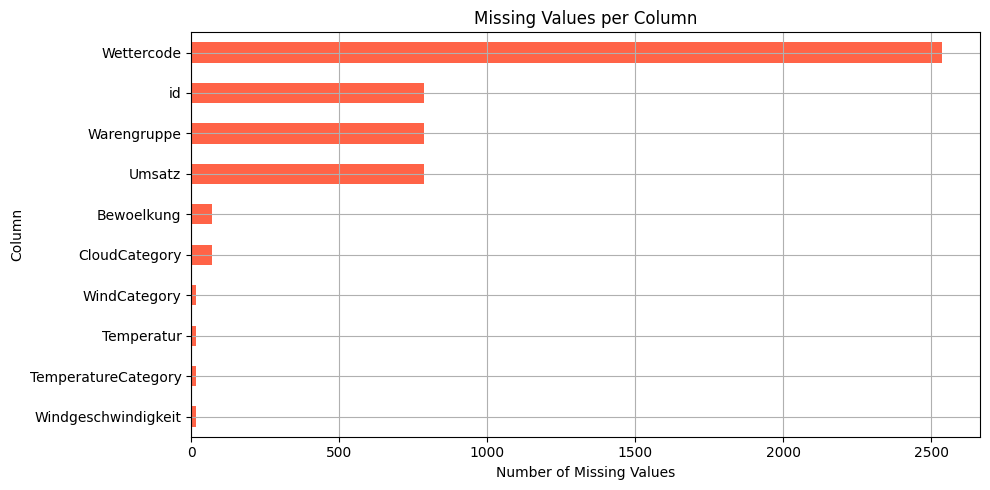

In [4]:
missing_counts = sale_weather_kiwo.isnull().sum()
missing_counts = missing_counts[missing_counts > 0]

plt.figure(figsize=(10, 5))
missing_counts.sort_values().plot(kind='barh', color='tomato')
plt.title("Missing Values per Column")
plt.xlabel("Number of Missing Values")
plt.ylabel("Column")
plt.grid(True)
plt.tight_layout()
plt.show()

## 📊 Feature Distributions – Numerical

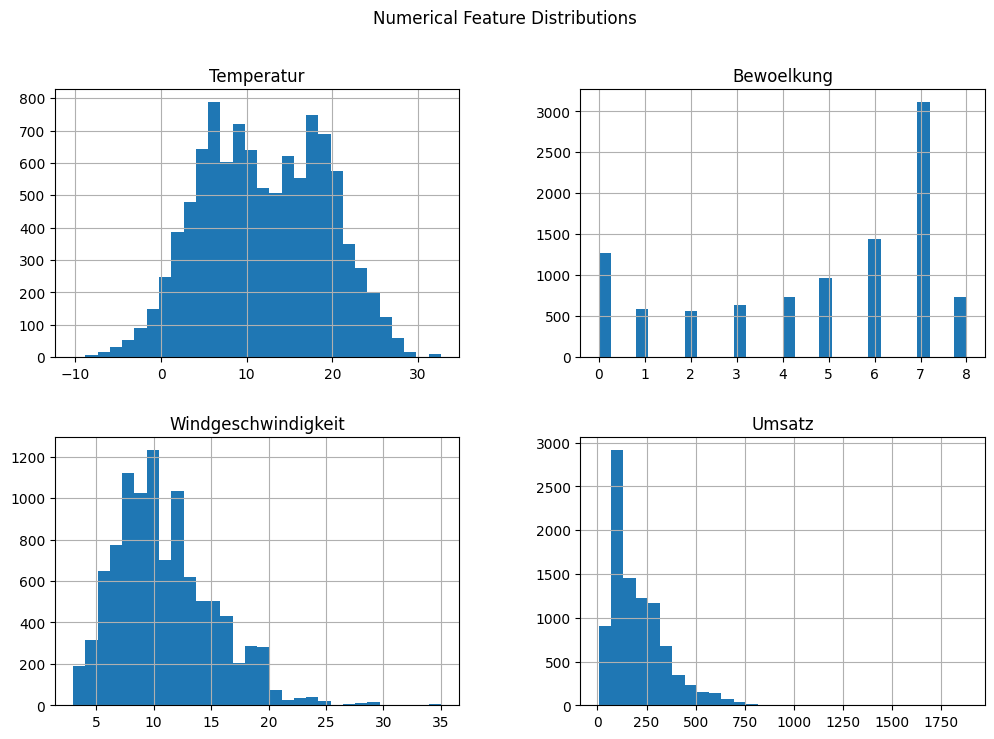

In [5]:
sale_weather_kiwo[['Temperatur', 'Bewoelkung', 'Windgeschwindigkeit', 'Umsatz']].hist(
    bins=30, figsize=(12, 8))
plt.suptitle("Numerical Feature Distributions")
plt.show()


## 📊 Feature Distributions – Categorical

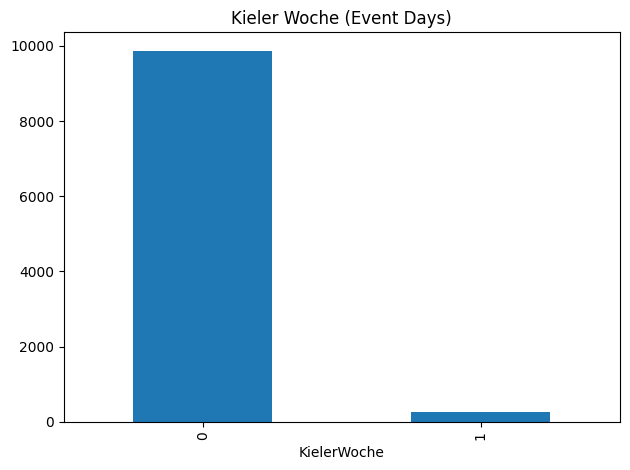

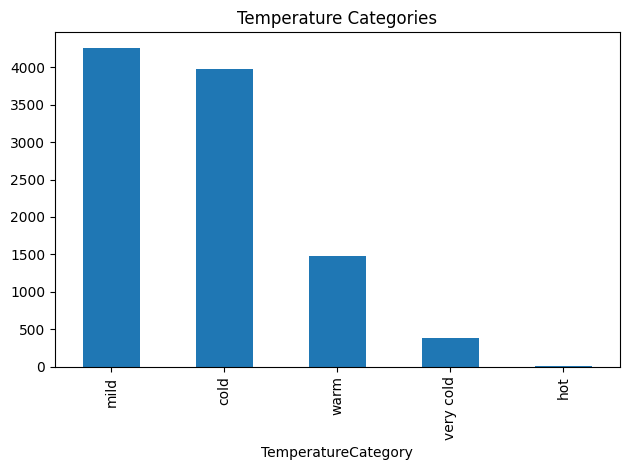

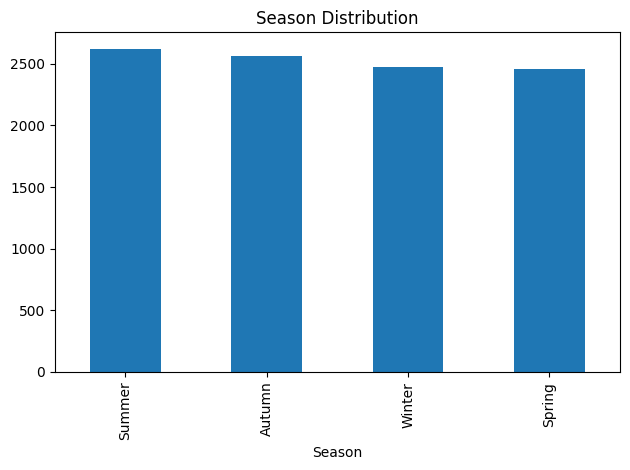

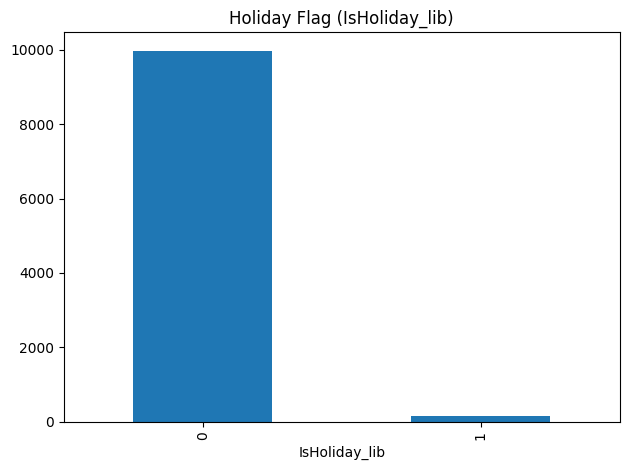

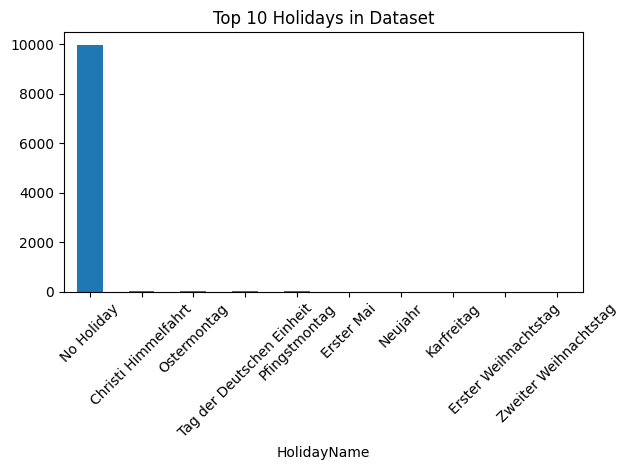

In [6]:
sale_weather_kiwo['KielerWoche'].value_counts().plot(kind='bar', title="Kieler Woche (Event Days)")
plt.tight_layout()
plt.show()

sale_weather_kiwo['TemperatureCategory'].value_counts().plot(kind='bar', title="Temperature Categories")
plt.tight_layout()
plt.show()

sale_weather_kiwo['Season'].value_counts().plot(kind='bar', title="Season Distribution")
plt.tight_layout()
plt.show()

sale_weather_kiwo['IsHoliday_lib'].value_counts().plot(kind='bar', title="Holiday Flag (IsHoliday_lib)")
plt.tight_layout()
plt.show()

top_holidays = sale_weather_kiwo['HolidayName'].value_counts().nlargest(10)
top_holidays.plot(kind='bar', title="Top 10 Holidays in Dataset")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 🔗 Correlation Analysis

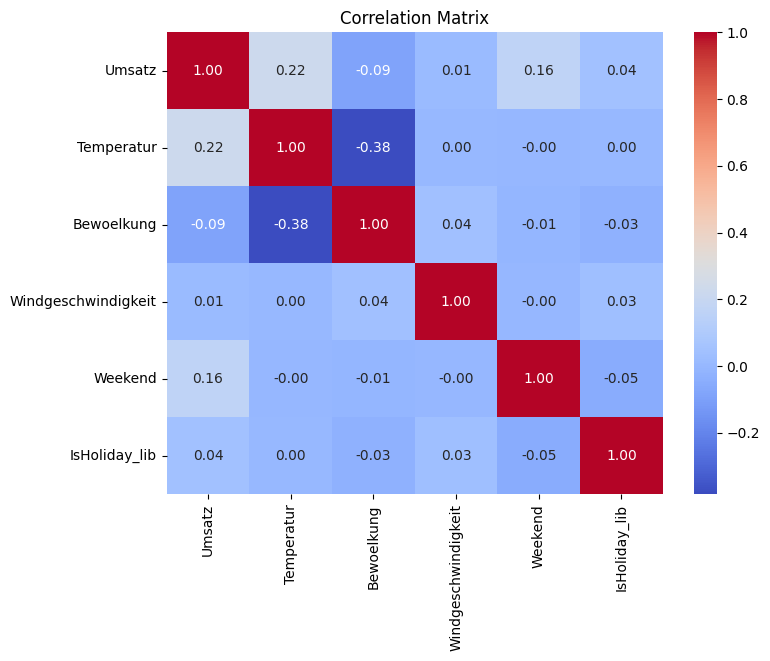

In [7]:
corr = sale_weather_kiwo[['Umsatz', 'Temperatur', 'Bewoelkung', 'Windgeschwindigkeit', 'Weekend', 'IsHoliday_lib']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

## ⏳ Sales Over Time

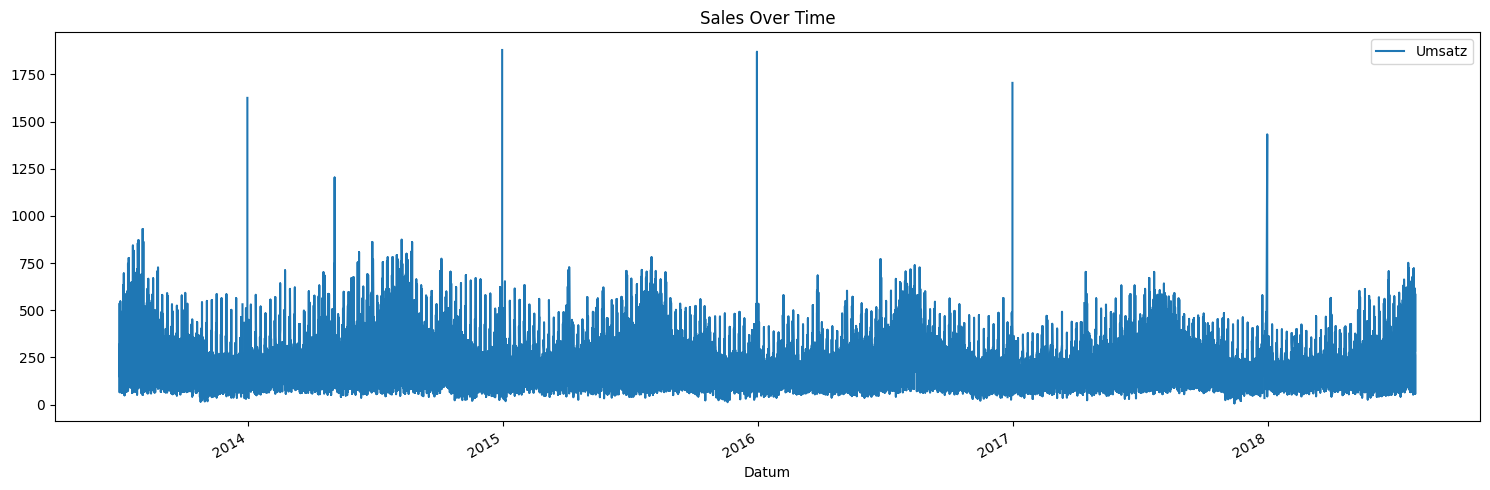

In [8]:
sale_weather_kiwo.plot(x='Datum', y='Umsatz', figsize=(15,5), title='Sales Over Time')
plt.tight_layout()
plt.show()


## 📦 Sales by Category (Weekend / Event)

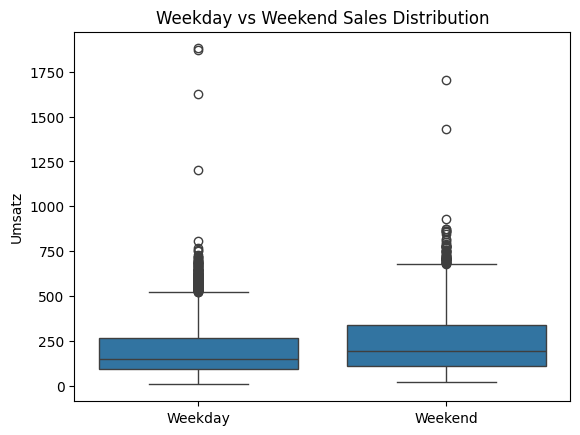

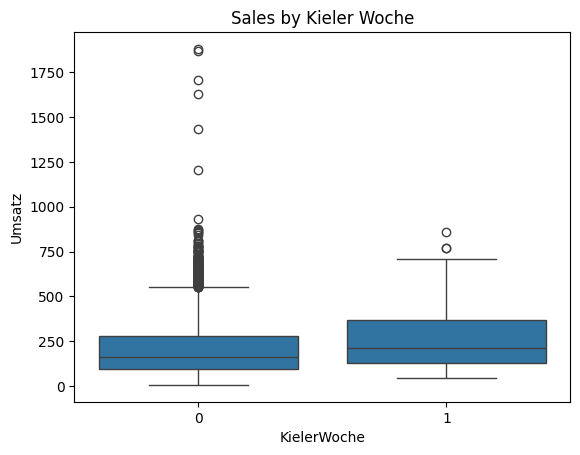

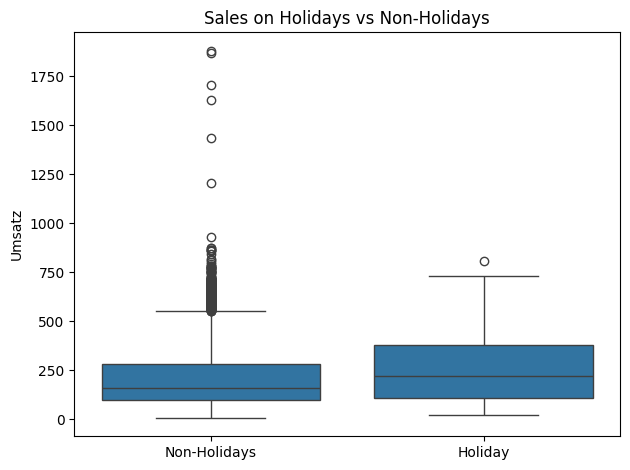

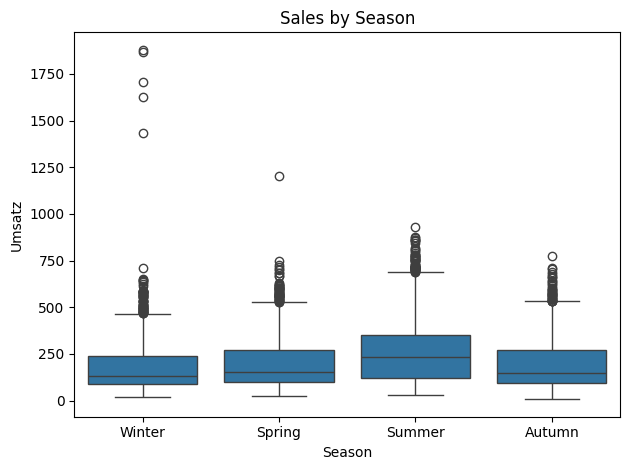

In [9]:

sns.boxplot(x='Weekend', y='Umsatz', data=sale_weather_kiwo)
plt.xticks(ticks=[0, 1], labels=['Weekday', 'Weekend'])
plt.title("Weekday vs Weekend Sales Distribution")
plt.xlabel("")
plt.show()

sns.boxplot(x='KielerWoche', y='Umsatz', data=sale_weather_kiwo)
plt.title("Sales by Kieler Woche")
plt.show()

sns.boxplot(x='IsHoliday_lib', y='Umsatz', data=sale_weather_kiwo)
plt.xticks(ticks=[0, 1], labels=['Non-Holidays', 'Holiday'])
plt.title("Sales on Holidays vs Non-Holidays")
plt.xlabel("")
plt.tight_layout()
plt.show()

sns.boxplot(x='Season', y='Umsatz', data=sale_weather_kiwo)
plt.title("Sales by Season")
plt.tight_layout()
plt.show()

**Significance test Weekday vs. Weekend**

Data counts:
Weekend records: 2678
Weekday records: 6656

Normality tests:
Weekend sales - Shapiro p-value: 2.1964444306796633e-40
Weekday sales - Shapiro p-value: 1.384727576264799e-44

Test results:
Mann-Whitney U statistic: 10337237.0
p-value: 0.00000
Cohen's d effect size: 0.365

Conclusion: There IS a statistically significant difference between weekend and weekday sales.
Weekend sales are significantly higher than weekday sales.

Summary statistics:
Weekend sales - Mean: 243.9135647402682 Median: 193.793341315291
Weekday sales - Mean: 191.79613203002904 Median: 150.544905385205


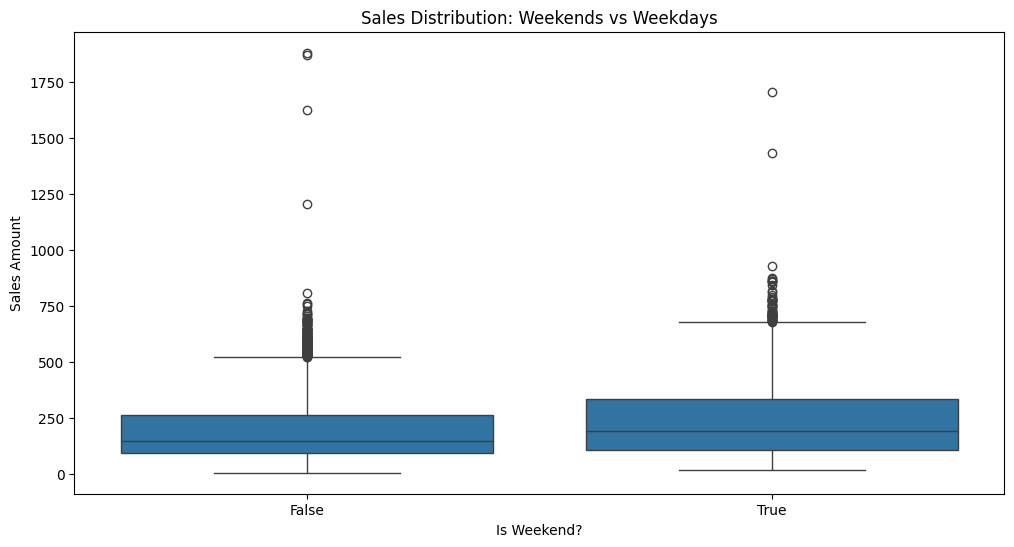

In [10]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Clean the data first
df_clean = sale_weather_kiwo.dropna(subset=['Umsatz']).copy()  # Remove rows with missing sales
df_clean['is_weekend'] = df_clean['Datum'].dt.dayofweek.isin([5, 6])  # 5=Saturday, 6=Sunday

# 2. Verify we have data for both groups
print("Data counts:")
print("Weekend records:", len(df_clean[df_clean['is_weekend']]))
print("Weekday records:", len(df_clean[~df_clean['is_weekend']]))

# 3. Split cleaned data
weekend_sales = df_clean[df_clean['is_weekend']]['Umsatz']
weekday_sales = df_clean[~df_clean['is_weekend']]['Umsatz']

# 4. Check for zero-variance (all values identical)
if weekend_sales.nunique() == 1 or weekday_sales.nunique() == 1:
    print("Warning: One group has no variability in sales")

# 5. Define Cohen's d function
def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1)**2 + (ny-1)*np.std(y, ddof=1)**2) / dof)

# 6. Run analysis only if we have sufficient data
if len(weekend_sales) > 3 and len(weekday_sales) > 3:
    # Normality tests (with sampling to avoid memory issues)
    sample_size = min(5000, len(weekend_sales), len(weekday_sales))

    if sample_size > 3:
        print("\nNormality tests:")
        print("Weekend sales - Shapiro p-value:",
              stats.shapiro(weekend_sales.sample(sample_size))[1] if sample_size <= 5000 else "Sample too large")
        print("Weekday sales - Shapiro p-value:",
              stats.shapiro(weekday_sales.sample(sample_size))[1] if sample_size <= 5000 else "Sample too large")

    # Statistical test
    stat, p_value = stats.mannwhitneyu(weekend_sales, weekday_sales, nan_policy='omit')

    # Effect size
    d = cohens_d(weekend_sales.dropna(), weekday_sales.dropna())

    print("\nTest results:")
    print(f"Mann-Whitney U statistic: {stat}")
    print(f"p-value: {p_value:.5f}")
    print(f"Cohen's d effect size: {d:.3f}")

    # Interpretation
    alpha = 0.05
    if p_value < alpha:
        print("\nConclusion: There IS a statistically significant difference between weekend and weekday sales.")
        if np.median(weekend_sales) > np.median(weekday_sales):
            print("Weekend sales are significantly higher than weekday sales.")
        else:
            print("Weekday sales are significantly higher than weekend sales.")
    else:
        print("\nConclusion: There is NO statistically significant difference between weekend and weekday sales.")

    print(f"\nSummary statistics:")
    print("Weekend sales - Mean:", np.mean(weekend_sales), "Median:", np.median(weekend_sales))
    print("Weekday sales - Mean:", np.mean(weekday_sales), "Median:", np.median(weekday_sales))

    # Visualization
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='is_weekend', y='Umsatz', data=df_clean)
    plt.title('Sales Distribution: Weekends vs Weekdays')
    plt.xlabel('Is Weekend?')
    plt.ylabel('Sales Amount')
    plt.show()
else:
    print("Insufficient data for analysis (need at least 4 records in each group)")

Data counts:
Weekend records: 2678
Weekday records: 6656

Normality tests:
Weekend sales - Shapiro p-value: 2.1964444306796633e-40
Weekday sales - Shapiro p-value: 1.8391090321139952e-44

Test results:
Mann-Whitney U statistic: 10337237.0
p-value: 0.00000
Cohen's d effect size: 0.365

Conclusion: Significant difference found (p < 0.05)
Weekend median: 193.793341315291
Weekday median: 150.544905385205

Summary statistics:
Weekend sales - Mean: 243.9135647402682 Median: 193.793341315291
Weekday sales - Mean: 191.79613203002904 Median: 150.544905385205


/tmp/ipython-input-11-937704411.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Weekend', y='Umsatz', data=df_clean,


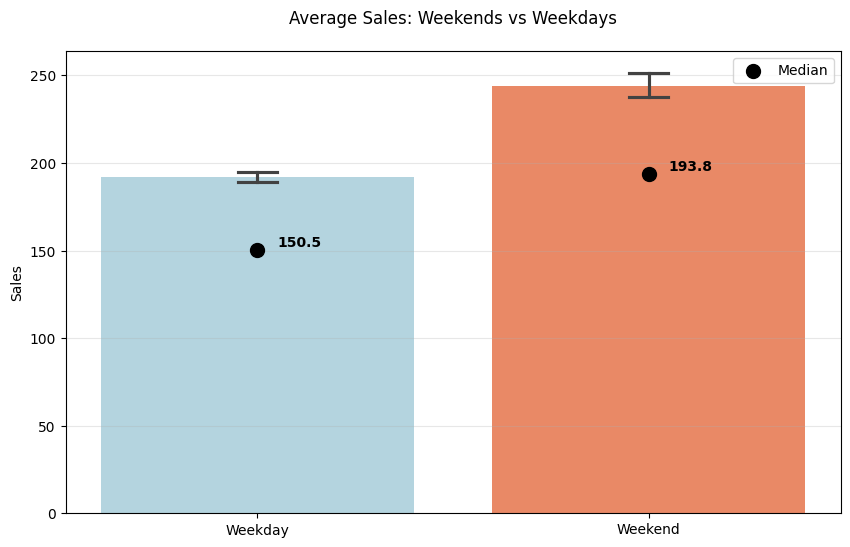

In [11]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Clean the data first
df_clean = sale_weather_kiwo.dropna(subset=['Umsatz', 'Weekend']).copy()

# 2. Verify we have data for both groups
print("Data counts:")
print("Weekend records:", len(df_clean[df_clean['Weekend'] == 1]))
print("Weekday records:", len(df_clean[df_clean['Weekend'] == 0]))

# 3. Split cleaned data
weekend_sales = df_clean[df_clean['Weekend'] == 1]['Umsatz']
weekday_sales = df_clean[df_clean['Weekend'] == 0]['Umsatz']

# 4. Check for zero-variance
if weekend_sales.nunique() == 1 or weekday_sales.nunique() == 1:
    print("Warning: One group has no variability in sales")

# 5. Define Cohen's d function
def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1)**2 + (ny-1)*np.std(y, ddof=1)**2) / dof)

# 6. Run analysis if sufficient data
if len(weekend_sales) > 3 and len(weekday_sales) > 3:
    # Normality tests
    sample_size = min(5000, len(weekend_sales), len(weekday_sales))
    if sample_size > 3:
        print("\nNormality tests:")
        print("Weekend sales - Shapiro p-value:",
              stats.shapiro(weekend_sales.sample(sample_size))[1] if sample_size <= 5000 else "Sample too large")
        print("Weekday sales - Shapiro p-value:",
              stats.shapiro(weekday_sales.sample(sample_size))[1] if sample_size <= 5000 else "Sample too large")

    # Statistical test
    stat, p_value = stats.mannwhitneyu(weekend_sales, weekday_sales, nan_policy='omit')

    # Effect size
    d = cohens_d(weekend_sales.dropna(), weekday_sales.dropna())

    print("\nTest results:")
    print(f"Mann-Whitney U statistic: {stat}")
    print(f"p-value: {p_value:.5f}")
    print(f"Cohen's d effect size: {d:.3f}")

    # Interpretation
    alpha = 0.05
    if p_value < alpha:
        print("\nConclusion: Significant difference found (p < 0.05)")
        print("Weekend median:", np.median(weekend_sales))
        print("Weekday median:", np.median(weekday_sales))
    else:
        print("\nConclusion: No significant difference found")

    print("\nSummary statistics:")
    print("Weekend sales - Mean:", np.mean(weekend_sales), "Median:", np.median(weekend_sales))
    print("Weekday sales - Mean:", np.mean(weekday_sales), "Median:", np.median(weekday_sales))

    # Visualization
    plt.figure(figsize=(10, 6))

    sns.barplot(x='Weekend', y='Umsatz', data=df_clean,
                palette=['lightblue', 'coral'],  # Colors in order [0, 1]
                errorbar= ('ci',95),
                capsize=0.1)

     # Add median markers
    medians = df_clean.groupby('Weekend')['Umsatz'].median()
    for i, weekend in enumerate([0, 1]):
        plt.scatter(i, medians[weekend], color='black', s=100, zorder=5, label='Median' if i == 0 else "")
        plt.text(i+0.05, medians[weekend], f'{medians[weekend]:.1f}',
                 ha='left', va='bottom', fontweight='bold')

    plt.title('Average Sales: Weekends vs Weekdays', pad=20)
    plt.xticks(ticks=[0, 1], labels=['Weekday', 'Weekend'])
    plt.xlabel('')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

else:
    print("Insufficient data for analysis (need at least 4 records in each group)")

Holidays


Holiday Analysis Data counts:
Holiday records: 100
Non-holiday records: 9234

Normality tests:
Holiday sales - Shapiro p-value: 3.7622018377565422e-06
Non-holiday sales - Shapiro p-value: 0.00016986408484046504

Test results:
Mann-Whitney U statistic: 539531.0
p-value: 0.00368
Cohen's d effect size: 0.424

Conclusion: Significant difference found (p < 0.05)
Holiday median: 222.027804972627
Non-holiday median: 161.461056593421

Summary statistics:
Holiday sales - Mean: 267.269149884645 Median: 222.027804972627
Non-holiday sales - Mean: 206.09363939547833 Median: 161.461056593421


/tmp/ipython-input-15-1952720834.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='IsHoliday', y='Umsatz', data=temp_df,


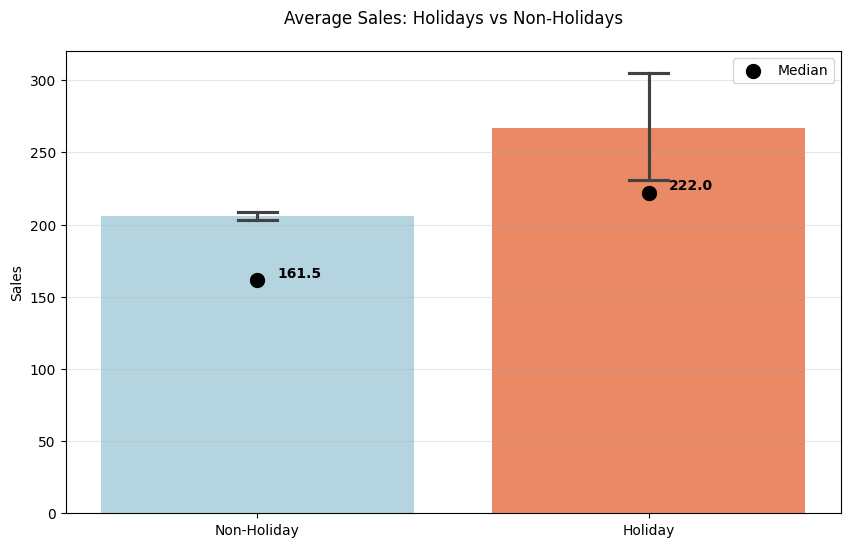


Individual Holiday Analysis:
HolidayName
Tag der Deutschen Einheit    25
Ostermontag                  25
Christi Himmelfahrt          25
Pfingstmontag                20
Erster Mai                    5
Name: count, dtype: int64


In [15]:
# 1. Clean the data for Holiday analysis
holiday_df = df_clean[df_clean['HolidayName'] != 'No Holiday'].copy()
non_holiday_df = df_clean[df_clean['HolidayName'] == 'No Holiday'].copy()

# 2. Verify we have data for both groups
print("\nHoliday Analysis Data counts:")
print("Holiday records:", len(holiday_df))
print("Non-holiday records:", len(non_holiday_df))

# 3. Split cleaned data
holiday_sales = holiday_df['Umsatz']
non_holiday_sales = non_holiday_df['Umsatz']

# 4. Check for zero-variance
if holiday_sales.nunique() == 1 or non_holiday_sales.nunique() == 1:
    print("Warning: One group has no variability in sales")

# 5. Run analysis if sufficient data
if len(holiday_sales) > 3 and len(non_holiday_sales) > 3:
    # Normality tests
    sample_size = min(5000, len(holiday_sales), len(non_holiday_sales))
    if sample_size > 3:
        print("\nNormality tests:")
        print("Holiday sales - Shapiro p-value:",
              stats.shapiro(holiday_sales.sample(sample_size))[1] if sample_size <= 5000 else "Sample too large")
        print("Non-holiday sales - Shapiro p-value:",
              stats.shapiro(non_holiday_sales.sample(sample_size))[1] if sample_size <= 5000 else "Sample too large")

    # Statistical test
    stat, p_value = stats.mannwhitneyu(holiday_sales, non_holiday_sales, nan_policy='omit')

    # Effect size
    d = cohens_d(holiday_sales.dropna(), non_holiday_sales.dropna())

    print("\nTest results:")
    print(f"Mann-Whitney U statistic: {stat}")
    print(f"p-value: {p_value:.5f}")
    print(f"Cohen's d effect size: {d:.3f}")

    # Interpretation
    alpha = 0.05
    if p_value < alpha:
        print("\nConclusion: Significant difference found (p < 0.05)")
        print("Holiday median:", np.median(holiday_sales))
        print("Non-holiday median:", np.median(non_holiday_sales))
    else:
        print("\nConclusion: No significant difference found")

    print("\nSummary statistics:")
    print("Holiday sales - Mean:", np.mean(holiday_sales), "Median:", np.median(holiday_sales))
    print("Non-holiday sales - Mean:", np.mean(non_holiday_sales), "Median:", np.median(non_holiday_sales))

    # Visualization
    plt.figure(figsize=(10, 6))

    # Create a temporary column for plotting
    temp_df = df_clean.copy()
    temp_df['IsHoliday'] = temp_df['HolidayName'].apply(lambda x: 'Holiday' if x != 'No Holiday' else 'Non-Holiday')

    sns.barplot(x='IsHoliday', y='Umsatz', data=temp_df,
                palette=['lightblue', 'coral'],
                errorbar= ('ci',95),
                capsize=0.1)
    # Add mean markers
    #means = temp_df.groupby('IsHoliday')['Umsatz'].mean()
    #for i, holiday in enumerate(['Non-Holiday', 'Holiday']):
    #    plt.text(i, means[holiday], f'{means[holiday]:.1f}',
    #             ha='left', va='bottom', fontweight='bold')

    # Add median markers
    medians = temp_df.groupby('IsHoliday')['Umsatz'].median()
    for i, holiday in enumerate(['Non-Holiday', 'Holiday']):
        plt.scatter(i, medians[holiday], color='black', s=100, zorder=5, label='Median' if i == 0 else "")
        plt.text(i +0.05, medians[holiday], f'{medians[holiday]:.1f}',
                 ha='left', va='bottom', fontweight='bold')

    plt.title('Average Sales: Holidays vs Non-Holidays', pad=20)
    plt.xlabel('')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

else:
    print("Insufficient data for holiday analysis (need at least 4 records in each group)")

# Additional analysis: Compare specific holidays if enough data
print("\nIndividual Holiday Analysis:")
holiday_counts = df_clean[df_clean['HolidayName'] != 'No Holiday']['HolidayName'].value_counts()
print(holiday_counts)

# You could add specific comparisons for holidays with sufficient data

Between holidays


Holiday Comparison Data counts:
HolidayName
Tag der Deutschen Einheit    25
Ostermontag                  25
Erster Mai                    5
Name: count, dtype: int64

Kruskal-Wallis Test results:
H-statistic: 0.07574025974025744
p-value: 0.96284
Effect size (eta squared): -0.037

Conclusion: No significant difference found among holidays

Summary statistics:
                                 mean      median         std  count
HolidayName                                                         
Erster Mai                 264.098700  223.802785  164.955400      5
Ostermontag                255.230002  222.678061  200.089497     25
Tag der Deutschen Einheit  259.131335  192.293311  181.870230     25


/tmp/ipython-input-19-4269276454.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='HolidayName', y='Umsatz', data=holiday_comparison_df,


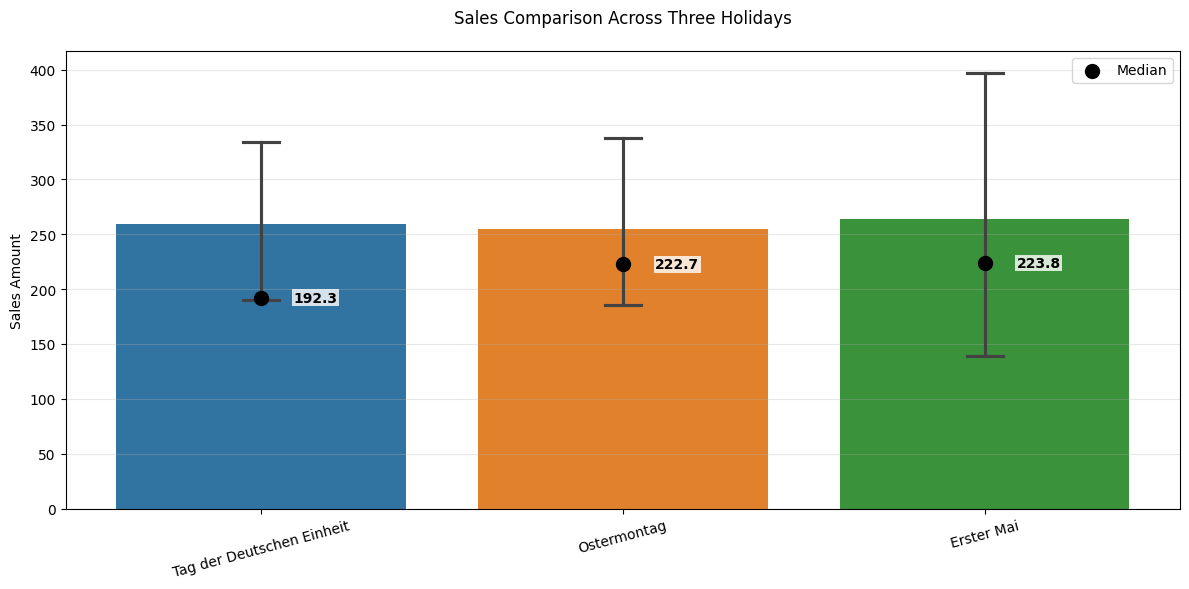

In [19]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for the three holidays we want to compare
holiday_comparison_df = df_clean[
    df_clean['HolidayName'].isin(['Tag der Deutschen Einheit', 'Ostermontag', 'Erster Mai'])
].copy()

# Verify we have data for all holidays
print("\nHoliday Comparison Data counts:")
print(holiday_comparison_df['HolidayName'].value_counts())

# Check if we have sufficient data
if all(holiday_comparison_df['HolidayName'].value_counts() > 3):
    # Statistical test - Kruskal-Wallis for multiple groups
    groups = [
        holiday_comparison_df[holiday_comparison_df['HolidayName'] == 'Tag der Deutschen Einheit']['Umsatz'],
        holiday_comparison_df[holiday_comparison_df['HolidayName'] == 'Ostermontag']['Umsatz'],
        holiday_comparison_df[holiday_comparison_df['HolidayName'] == 'Erster Mai']['Umsatz']
    ]

    stat, p_value = stats.kruskal(*groups, nan_policy='omit')

    print("\nKruskal-Wallis Test results:")
    print(f"H-statistic: {stat}")
    print(f"p-value: {p_value:.5f}")

    # Effect size (eta squared)
    def eta_squared_kruskal(H, n, k):
        return (H - k + 1)/(n - k)

    n = len(holiday_comparison_df)
    k = 3  # number of groups
    eta2 = eta_squared_kruskal(stat, n, k)

    print(f"Effect size (eta squared): {eta2:.3f}")

    # Interpretation
    alpha = 0.05
    if p_value < alpha:
        print("\nConclusion: Significant difference found among holidays (p < 0.05)")

        # Post-hoc pairwise comparisons
        print("\nPost-hoc pairwise comparisons (Mann-Whitney U):")
        holidays = ['Tag der Deutschen Einheit', 'Ostermontag', 'Erster Mai']
        for i in range(len(holidays)):
            for j in range(i+1, len(holidays)):
                stat, p = stats.mannwhitneyu(
                    holiday_comparison_df[holiday_comparison_df['HolidayName'] == holidays[i]]['Umsatz'],
                    holiday_comparison_df[holiday_comparison_df['HolidayName'] == holidays[j]]['Umsatz'],
                    nan_policy='omit'
                )
                print(f"{holidays[i]} vs {holidays[j]}: p-value = {p:.4f}")
    else:
        print("\nConclusion: No significant difference found among holidays")

    print("\nSummary statistics:")
    print(holiday_comparison_df.groupby('HolidayName')['Umsatz'].agg(['mean', 'median', 'std', 'count']))

    # Visualization
    plt.figure(figsize=(12, 6))

    # Order holidays for plotting
    holiday_order = ['Tag der Deutschen Einheit', 'Ostermontag', 'Erster Mai']

    ax = sns.barplot(x='HolidayName', y='Umsatz', data=holiday_comparison_df,
                    order=holiday_order,
                    palette=['#1f77b4', '#ff7f0e', '#2ca02c'],  # Different colors for each holiday
                    errorbar=('ci', 95),
                    capsize=0.1)

    # Add median markers in the center of each bar
    medians = holiday_comparison_df.groupby('HolidayName')['Umsatz'].median()[holiday_order]
    for i, holiday in enumerate(holiday_order):
        # Center position of the bar
        x_pos = i

        # Add the black median dot
        plt.scatter(x_pos, medians[holiday], color='black', s=100, zorder=5, label='Median' if i == 0 else "")

        # Add the median value text
        plt.text((x_pos+0.15), medians[holiday], f'{medians[holiday]:.1f}',
                 ha='center', va='center', fontweight='bold',
                 bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=1))

    plt.title('Sales Comparison Across Three Holidays', pad=20)
    plt.xlabel('')
    plt.ylabel('Sales Amount')
    plt.xticks(rotation=15)  # Slight rotation for long holiday names
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()  # Adjust layout to prevent label cutoff
    plt.show()

else:
    print("\nInsufficient data for comparison (need at least 4 records for each holiday)")

    # Show available data if insufficient
    if len(holiday_comparison_df) > 0:
        print("\nAvailable data points:")
        print(holiday_comparison_df[['Datum', 'HolidayName', 'Umsatz']].sort_values('Datum'))

Seasons


Season Analysis Data counts:
Season
Autumn    2410
Summer    2405
Winter    2293
Spring    2226
Name: count, dtype: int64

Normality tests by season:
Summer - Shapiro p-value: 4.634431717600934e-35
Autumn - Shapiro p-value: 2.1380464531154717e-36
Winter - Shapiro p-value: 6.434337609219519e-52
Spring - Shapiro p-value: 1.132016016335606e-37

Test results:
Kruskal-Wallis H statistic: 409.9608549555087
p-value: 0.00000

Conclusion: Significant difference found between seasons (p < 0.05)

Post-hoc pairwise comparisons:
Summer vs Autumn: p-value = 0.0000
Summer vs Winter: p-value = 0.0000
Summer vs Spring: p-value = 0.0000
Autumn vs Winter: p-value = 0.0000
Autumn vs Spring: p-value = 0.0734
Winter vs Spring: p-value = 0.0000

Summary statistics by season:
              mean      median         std  count
Season                                           
Autumn  190.852513  149.459761  123.728299   2410
Spring  196.869054  155.544335  125.362500   2226
Summer  263.074568  232.925986  174.

/tmp/ipython-input-18-1517591496.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Season', y='Umsatz', data=season_df,


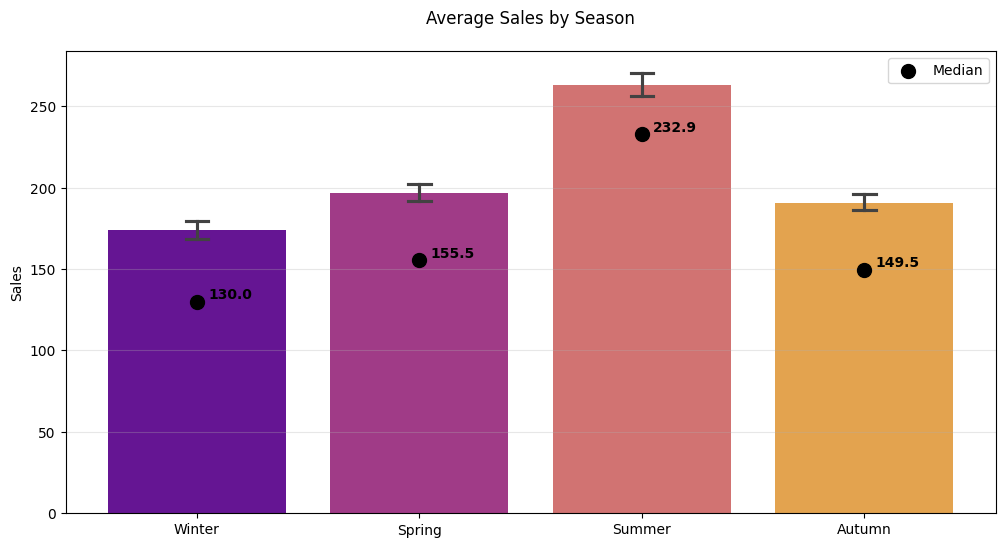

In [18]:
# 1. Clean the data for Season analysis
season_df = df_clean.dropna(subset=['Season', 'Umsatz']).copy()

# 2. Verify we have data for all seasons
print("\nSeason Analysis Data counts:")
print(season_df['Season'].value_counts())

# 3. Check if we have at least 4 records per season
if all(season_df['Season'].value_counts() > 3):
    # Normality tests by season
    print("\nNormality tests by season:")
    for season in season_df['Season'].unique():
        sample = season_df[season_df['Season'] == season]['Umsatz']
        sample_size = min(5000, len(sample))
        if sample_size > 3:
            print(f"{season} - Shapiro p-value:",
                  stats.shapiro(sample.sample(sample_size))[1] if sample_size <= 5000 else "Sample too large")

    # Kruskal-Wallis test for multiple groups
    groups = [season_df[season_df['Season'] == season]['Umsatz'] for season in season_df['Season'].unique()]
    stat, p_value = stats.kruskal(*groups, nan_policy='omit')

    print("\nTest results:")
    print(f"Kruskal-Wallis H statistic: {stat}")
    print(f"p-value: {p_value:.5f}")

    # Interpretation
    alpha = 0.05
    if p_value < alpha:
        print("\nConclusion: Significant difference found between seasons (p < 0.05)")

        # Post-hoc pairwise comparisons
        print("\nPost-hoc pairwise comparisons:")
        seasons = season_df['Season'].unique()
        for i in range(len(seasons)):
            for j in range(i+1, len(seasons)):
                stat, p = stats.mannwhitneyu(
                    season_df[season_df['Season'] == seasons[i]]['Umsatz'],
                    season_df[season_df['Season'] == seasons[j]]['Umsatz'],
                    nan_policy='omit'
                )
                print(f"{seasons[i]} vs {seasons[j]}: p-value = {p:.4f}")
    else:
        print("\nConclusion: No significant difference found between seasons")

    print("\nSummary statistics by season:")
    print(season_df.groupby('Season')['Umsatz'].agg(['mean', 'median', 'std', 'count']))

    # Visualization
    plt.figure(figsize=(12, 6))

    # Order seasons logically
    season_order = ['Winter', 'Spring', 'Summer', 'Autumn']

    sns.barplot(x='Season', y='Umsatz', data=season_df,
                order=season_order,
                palette='plasma',
                errorbar=('ci', 95),
                capsize=0.1)

    # Add median markers
    medians = season_df.groupby('Season')['Umsatz'].median().loc[season_order]
    for i, season in enumerate(season_order):
        plt.scatter(i, medians[season], color='black', s=100, zorder=5, label='Median' if i == 0 else "")
        plt.text(i +0.05 , medians[season], f'{medians[season]:.1f}',
                 ha='left', va='bottom', fontweight='bold')

    plt.title('Average Sales by Season', pad=20)
    plt.xlabel('')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

else:
    print("Insufficient data for season analysis (need at least 4 records in each season)")